In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [3]:
class ClassHeatSimulation: 
    #presets
    TempLeftEnd = 200
    Temp_Fluid = 40
    TimeInc = 10
    Density = 7800
    Thermal_Conduct = 50
    Heat_Cap = 470
    Conv_Coeff = 50
    NumNodes = 4
    TotalLength = .1
    Length = 25.0E-3
    Dia = 3.0E-3
    LateralHeat = True
    InitialTemp = 200
    GlobalTime = 0
    ConstThermResistLeft = 0
    ConstThermResistRight = 0
    ConstThermResistCircum = 0
    ThermCapacitance = 0
    Volume = 0
    Temps = [0]
    Tempatures = {'Time':[0]}
    AllTemp = pd.DataFrame(Tempatures)
    SugTime = []
    LocalTemps = []
    Props = []
    PropsTable = pd.DataFrame(Props)
    
    
    def SetNodes(self,InputNumberNodes, InputTotalThickness):
        self.NumNodes = InputNumberNodes
        self.TotalLength = InputTotalThickness
        self.Length = self.TotalLength/self.NumNodes
        self.SuggestedTimeInc(True)
    def SetDiameter(self,D):
        self.Dia = D
    def SetMaterialProperties(self,InputDensity,InputHeatCapacity,InputThermalConductivity):
        self.Density = InputDensity
        self.Heat_Cap = InputHeatCapacity
        self.Thermal_Conduct = InputThermalConductivity
    def SetConvectionProperties(self,InputConvectionCoeff,InputTempature):
        self.Conv_Coeff = InputConvectionCoeff
        self.Temp_Fluid = InputTempature
    def EnableLateralHeatTransfer(self,Boolean):
        self.LateralHeat = Boolean
    def SetTimeIncrement(self,InputTimeInc):
        self.TimeInc = InputTimeInc
        #give recomendation based on JP Holman
        #Recommendation = "Confirmed"
        #print(Recommendation)
    def SetHeatSource(self, InputTemp):
        self.TempLeftEnd = InputTemp
    def SetInitalTemp(self,InputInitTemp):
        self.InitialTemp = InputInitTemp
    def _SetInitalTempProfile(self,InputArrayTemp):
        #only works if # of nodes Matches
        self.Temps = InputArrayTemp
        self.__CreateDF()
    def SaveDFtoCSV(self, Name):
        print(self.AllTemp)
        self.AllTemp.to_csv(Name, index=False)
    def GetTempatureAtNodeAtTime(self,StartTime,EndTime,Node):
        self.UpdatePropertiesTable()
        if Node > self.NumNodes or Node <= 0:
            return "Error: Node Number Invalid"
        Time = EndTime - StartTime
        if Time % self.TimeInc != 0:
            print("Time Invalid, rounding...")
            NumSteps = Time/self.TimeInc
            NumSteps = round(NumSteps)
            print(NumSteps)
            NewTime = NumSteps * self.TimeInc
            Print = "New Timestep is " + str(NewTime)
            print(Print)
        else:
            NumSteps = Time/self.TimeInc
        #print(NumSteps)
        if StartTime == 0:
            self.GlobalTime = 0
            self.CreateDF()
            Step = 0
            while Step < NumSteps:
                Step = Step + 1
                self.CalculateAllNodes() 
        elif StartTime == self.GlobalTime:
            Step = 0
            while Step < NumSteps:
                #print("bruh")
                Step = Step + 1
                self.CalculateAllNodes() 
        elif StartTime != self.GlobalTime or StartTime != 0:
            #print("why")
            self.GlobalTime = 0
            self.CreateDF()
            if StartTime % self.TimeInc != 0:
                print("Time Window Invalid, approximating")
                NumPreSteps = StartTime/self.TimeInc
                NumPreSteps = round(NumPreSteps)
            else:
                NumPreSteps = StartTime/self.TimeInc
            PreStep = 0
            while PreStep < NumPreSteps:
                PreStep = PreStep + 1
                self.CalculateAllNodes()
            Step = 0
            while Step < NumSteps:
                Step = Step + 1
                self.CalculateAllNodes() 
        print(self.GlobalTime)
        self.UpdatePropertiesTable()
        return self.Temps[Node]
    
    def Properties(self,NodeNumber):
        CircumSurfaceArea = np.pi*self.Length*self.Dia
        EndSurfaceArea = np.pi*(self.Dia*1/2)**2
        self.Volume = EndSurfaceArea*self.Length
        self.ConstThermResistLeft = self.Length/(EndSurfaceArea*self.Thermal_Conduct)
        if NodeNumber == self.NumNodes:
            # for final Node
            self.ConstThermResistRight = 1/(EndSurfaceArea*self.Conv_Coeff)
            self.ConstThermResistCircum = 2/(CircumSurfaceArea*self.Conv_Coeff)
            self.ThermCapacitance = self.Density*self.Volume*self.Heat_Cap/2
        else:  
            self.ConstThermResistRight = self.Length/(EndSurfaceArea*self.Thermal_Conduct)
            self.ConstThermResistCircum = 1/(CircumSurfaceArea*self.Conv_Coeff)
            self.ThermCapacitance = self.Density*self.Volume*self.Heat_Cap
        return 
    def CalcTemp(self,LeftTemp, SelfTemp, RightTemp,NodeN):
        self.Properties(NodeN)
        ResistL = (LeftTemp - SelfTemp)/self.ConstThermResistLeft
        ResistR = (RightTemp - SelfTemp)/self.ConstThermResistRight
        if self.LateralHeat == True:
            ResistC = (self.Temp_Fluid - SelfTemp)/self.ConstThermResistCircum
        else:
            ResistC = 0
        Temperature = self.TimeInc/self.ThermCapacitance*(ResistL + ResistR + ResistC)+SelfTemp
        return Temperature 
    def UpdatePropertiesTable(self):
        self.Props = {'Node':[1]}
        self.PropsTable = pd.DataFrame(self.Props)
        Values = [0,0,0,0,0]
        a = 0
        self.PropsTable['R_Left'] = 0
        self.PropsTable['R_Right'] = 0
        self.PropsTable['R_Circum'] = 0
        self.PropsTable['ThermCap'] = 0
        while a < self.NumNodes:
            a = a + 1
            self.Properties(a)
            Values[0] = a
            Values[1] = self.ConstThermResistLeft
            Values[2] = self.ConstThermResistRight
            Values[3] = self.ConstThermResistCircum
            Values[4] = self.ThermCapacitance
            
            if a == 1:
                self.PropsTable.loc[0] = Values
            else:
                self.PropsTable.loc[len(self.PropsTable.index)] = Values
        #print(self.PropsTable)
        
        
        
        
        
        
    def CreateDF(self):
        self.Tempatures = {'Time':[0]}
        self.AllTemp = pd.DataFrame(self.Tempatures)
        self.InputTemp(self.InitialTemp)
        a = 0
        while a < self.NumNodes:
            a = a + 1
            ColumnName = 'Node' + str(a)
            self.AllTemp[ColumnName] = [self.Temps[a]]
    def UpdateDF(self, CurrentTemp):
        self.AllTemp.loc[len(self.AllTemp.index)] = CurrentTemp
        #print(self.AllTemp)
    def CalculateAllNodes(self):
        self.LocalTemps.clear()
        self.LocalTemps.append(0)
        LNode = 0
        while LNode < self.NumNodes:
            LNode = LNode + 1
            BeforeLocalNode = LNode - 1
            
            if BeforeLocalNode <= 0:
                BeforeLocalTemp = self.TempLeftEnd
            else:
               #
                BeforeLocalTemp = self.Temps[BeforeLocalNode]

            #print(self.Temps)
            LocalTemp = self.Temps[LNode]
            AfterLocalNode = LNode + 1
            
            if AfterLocalNode > self.NumNodes:
                AfterLocalTemp = self.Temp_Fluid
            else:
                AfterLocalTemp = self.Temps[AfterLocalNode]
            #print(BeforeLocalTemp, LocalTemp, AfterLocalTemp, LNode)
            LocalTemp = self.CalcTemp(BeforeLocalTemp, LocalTemp, AfterLocalTemp, LNode)
            self.LocalTemps.append(LocalTemp)
        L = 0
        while L < self.NumNodes:
            L = L + 1
            #print(L)
            #print(self.Temps)
            #print(self.LocalTemps)
            self.Temps[L] = self.LocalTemps[L]
        self.GlobalTime = self.Temps[0] + self.TimeInc
        self.Temps[0] = self.GlobalTime
        self.UpdateDF(self.Temps)
        #print(self.Temps)
    def InputTemp(self,StartTemp):
        a = 0
        self.Temps = [0]
        while a < self.NumNodes:
            a = a + 1
            self.Temps.append(StartTemp)
    #time step recomendation
    def SuggestedTimeInc(self,Return):
        NN= 0
        self.SugTime.clear()
        while NN < self.NumNodes:
            NN = NN + 1
            self.Properties(NN)
            R = (1/self.ConstThermResistLeft+1/self.ConstThermResistRight+1/self.ConstThermResistCircum)
            TimeSuggestion = (self.ThermCapacitance)/(R)
            TimeSuggestion = TimeSuggestion - (2/5)*(TimeSuggestion)
            if (round(TimeSuggestion)) > 2:
                self.SugTime.append(round(TimeSuggestion))
            elif (round(TimeSuggestion,1)) > .2:
                self.SugTime.append(round(TimeSuggestion,1))
            else:
                self.SugTime.append(round(TimeSuggestion,2))
        #self.TimeInc = min(self.SugTime)
        if Return == True:
            print(self.TimeInc)
            return self.TimeInc
HeatSimulation = ClassHeatSimulation()

In [4]:
HeatSimulation.UpdatePropertiesTable()
HeatSimulation.PropsTable

,Node,R_Left,R_Right,R_Circum,ThermCap
0,1.0,70.73553,70.735530,84.882636,0.647836
1,2.0,70.73553,70.735530,84.882636,0.647836
2,3.0,70.73553,70.735530,84.882636,0.647836
3,4.0,70.73553,2829.421211,169.765273,0.323918


In [9]:
HeatSimulation.SetDiameter(.003)
HeatSimulation.SetNodes(4,.10)
HeatSimulation.SetMaterialProperties(7800,470,50)
HeatSimulation.SetConvectionProperties(50,40)
HeatSimulation.EnableLateralHeatTransfer(False)
HeatSimulation.SetHeatSource(200)
HeatSimulation.SetInitalTemp(200)

10


In [8]:
print(HeatSimulation.GetTempatureAtNodeAtTime(0,7000,1))
HeatSimulation.AllTemp

7000
nan


,Time,Node1,Node2,Node3,Node4
0,0.0,200.000000,2.000000e+02,2.000000e+02,2.000000e+02
1,10.0,200.000000,2.000000e+02,2.000000e+02,1.825423e+02
2,20.0,200.000000,2.000000e+02,-1.809650e+02,9.289193e+02
3,30.0,200.000000,-8.113474e+03,3.235257e+04,-4.760819e+04
4,40.0,-181217.882032,1.056360e+06,-2.595619e+06,3.447422e+06
...,...,...,...,...,...
696,6960.0,NaN,NaN,NaN,NaN
697,6970.0,NaN,NaN,NaN,NaN
698,6980.0,NaN,NaN,NaN,NaN
699,6990.0,NaN,NaN,NaN,NaN


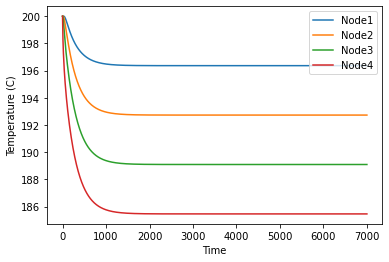

In [427]:
dfValidate4 = HeatSimulation.AllTemp
plt.figure()
plt.plot(dfValidate4.Time, dfValidate4.Node1, label="Node1")
plt.plot(dfValidate4.Time, dfValidate4.Node2, label="Node2")
plt.plot(dfValidate4.Time, dfValidate4.Node3, label="Node3")
plt.plot(dfValidate4.Time, dfValidate4.Node4, label="Node4")
#plt.plot(dfValidate4.Time, np.ones(np.shape(dfValidate4.Time))*40, label="Fluid")
plt.xlabel("Time")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()

In [421]:
print(HeatSimulation.GetTempatureAtNodeAtTime(0,21996,1))
HeatSimulation.AllTemp

Time Invalid, rounding...
2200
New Timestep is 22000
196.36363636363654


,Time,Node1,Node2,Node3,Node4
0,0.0,200.000000,200.000000,200.000000,200.000000
1,10.0,200.000000,200.000000,200.000000,198.254228
2,20.0,200.000000,200.000000,199.619035,197.289434
3,30.0,200.000000,199.916865,199.193801,196.589975
4,40.0,199.981858,199.777219,198.783378,196.017832
...,...,...,...,...,...
2196,21960.0,196.363636,192.727273,189.090909,185.454545
2197,21970.0,196.363636,192.727273,189.090909,185.454545
2198,21980.0,196.363636,192.727273,189.090909,185.454545
2199,21990.0,196.363636,192.727273,189.090909,185.454545


In [5]:
print(HeatSimulation.GetTempatureAtNodeAtTime(100,140,1))

127.32962273677238


In [413]:
HeatSimulation.AllTemp

,Time,Node1,Node2,Node3,Node4
0,0.0,200.000000,200.000000,200.000000,200.000000
1,10.0,170.903801,170.903801,170.903801,169.158029
2,20.0,153.448198,147.098781,146.717817,145.023157
3,30.0,141.590526,128.925179,127.024372,125.518272
4,40.0,133.098514,115.103079,111.285015,109.690898
5,50.0,126.840785,104.539298,98.807059,96.952860
6,60.0,122.146929,96.418512,88.959194,86.783747
7,70.0,118.583128,90.145446,81.208958,78.715062
8,80.0,115.853886,85.282014,75.120969,72.340700
9,90.0,113.750813,81.501504,70.344821,67.320061


In [329]:
HeatSimulation.CreateDF()

In [369]:
HeatSimulation.CalculateAllNodes()

200 148.91630273521662 118.66520867169803 1
148.91630273521662 118.66520867169803 101.21656653941417 2
118.66520867169803 101.21656653941417 91.44380728752843 3
101.21656653941417 91.44380728752843 86.12120774887086 4
91.44380728752843 86.12120774887086 83.27346872144896 5
86.12120774887086 83.27346872144896 81.75166775381246 6
83.27346872144896 81.75166775381246 80.96455263423928 7
81.75166775381246 80.96455263423928 40 8
[75, 148.42967931082242, 117.7261230523979, 99.88692503840473, 89.80261576194015, 84.2531293367083, 81.25988628639827, 79.66627900950758, 78.87377283050522]


In [343]:
HeatSimulation.CalcTemp(191.271140,191.271140,191.271140,2)

183.018486426623

In [255]:
HeatSimulation.Properties(4)

In [401]:
HeatSimulation.SaveDFtoCSV('Example_4-11_8Node.csv')

     Time       Node1       Node2       Node3       Node4       Node5  \
0     0.0  200.000000  200.000000  200.000000  200.000000  200.000000   
1     3.0  191.271140  191.271140  191.271140  191.271140  191.271140   
2     6.0  185.304276  183.018487  183.018487  183.018487  183.018487   
3     9.0  180.626884  175.814630  175.216060  175.216060  175.216060   
4    12.0  176.767924  169.508632  167.996042  167.839297  167.820488   
..    ...         ...         ...         ...         ...         ...   
79  237.0  142.024173  105.262603   82.017553   67.410559   58.367565   
80  240.0  142.013494  105.241692   81.987281   67.372187   58.322689   
81  243.0  142.003515  105.222149   81.958991   67.336327   58.280749   
82  246.0  141.994189  105.203887   81.932552   67.302813   58.241552   
83  249.0  141.985474  105.186820   81.907844   67.271492   58.204920   

         Node6       Node7       Node8  
0   200.000000  200.000000  200.000000  
1   191.271140  191.271140  190.223677  


In [387]:


dfValidate = pd.read_csv('8Node.csv')

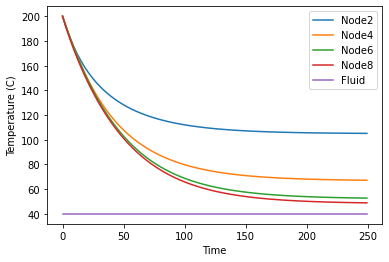

In [388]:

# plt.figure()
# plt.plot(dfValidate.Time, dfValidate.Node1, label="Node1")
# plt.plot(dfValidate.Time, dfValidate.Node2, label="Node2")
# plt.plot(dfValidate.Time, dfValidate.Node3, label="Node3")
# plt.plot(dfValidate.Time, dfValidate.Node4, label="Node4")
# plt.plot(dfValidate.Time, dfValidate.Node5, label="Node5")
# plt.plot(dfValidate.Time, dfValidate.Node6, label="Node6")
# plt.plot(dfValidate.Time, dfValidate.Node7, label="Node7")
# plt.plot(dfValidate.Time, dfValidate.Node8, label="Node8")
# plt.plot(dfValidate.Time, np.ones(np.shape(dfValidate.Time))*40, label="Fluid")
# plt.xlabel("Time")
# plt.ylabel("Temperature (C)")
# plt.legend()
# plt.show()
plt.figure()
plt.plot(dfValidate.Time, dfValidate.Node2, label="Node2")
plt.plot(dfValidate.Time, dfValidate.Node4, label="Node4")
plt.plot(dfValidate.Time, dfValidate.Node6, label="Node6")
plt.plot(dfValidate.Time, dfValidate.Node8, label="Node8")
plt.plot(dfValidate.Time, np.ones(np.shape(dfValidate.Time))*40, label="Fluid")
plt.xlabel("Time")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()


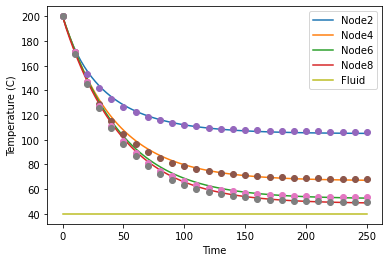

In [417]:
dfValidate4 = pd.read_csv('4Node.csv')
dfValidate8 = pd.read_csv('8Node.csv')
plt.figure()
plt.plot(dfValidate8.Time, dfValidate8.Node2, label="Node2")
plt.plot(dfValidate8.Time, dfValidate8.Node4, label="Node4")
plt.plot(dfValidate8.Time, dfValidate8.Node6, label="Node6")
plt.plot(dfValidate8.Time, dfValidate8.Node8, label="Node8")
plt.plot(dfValidate4.Time, dfValidate4.Node1, marker='o', linestyle='None')
plt.plot(dfValidate4.Time, dfValidate4.Node2, marker='o', linestyle='None')
plt.plot(dfValidate4.Time, dfValidate4.Node3, marker='o', linestyle='None')
plt.plot(dfValidate4.Time, dfValidate4.Node4, marker='o', linestyle='None')
plt.plot(dfValidate4.Time, np.ones(np.shape(dfValidate4.Time))*40, label="Fluid")
plt.xlabel("Time")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()

4 Node = the markers,
These show how increasing nodes still produces the same result at a given position and time.

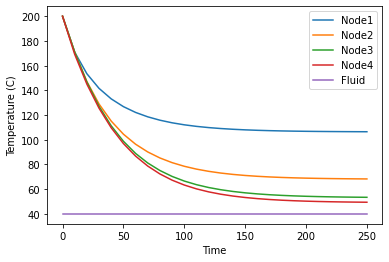

In [385]:
dfValidate4 = pd.read_csv('4Node.csv')
plt.figure()
plt.plot(dfValidate4.Time, dfValidate.Node1, label="Node1")
plt.plot(dfValidate4.Time, dfValidate.Node2, label="Node2")
plt.plot(dfValidate4.Time, dfValidate.Node3, label="Node3")
plt.plot(dfValidate4.Time, dfValidate.Node4, label="Node4")
plt.plot(dfValidate.Time, np.ones(np.shape(dfValidate.Time))*40, label="Fluid")
plt.xlabel("Time")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()

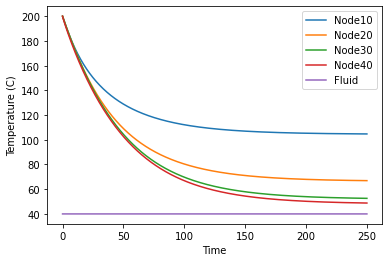

In [393]:
dfValidate = pd.read_csv('40Node.csv')
plt.figure()
plt.plot(dfValidate.Time, dfValidate.Node10, label="Node10")
plt.plot(dfValidate.Time, dfValidate.Node20, label="Node20")
plt.plot(dfValidate.Time, dfValidate.Node30, label="Node30")
plt.plot(dfValidate.Time, dfValidate.Node40, label="Node40")
plt.plot(dfValidate.Time, np.ones(np.shape(dfValidate.Time))*40, label="Fluid")
plt.xlabel("Time")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()